### Imports

In [1]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import Sampler
from qiskit.visualization import plot_distribution
from qiskit import Aer, transpile

import matplotlib.pyplot as plt
import numpy as np

### Ideal calculations:

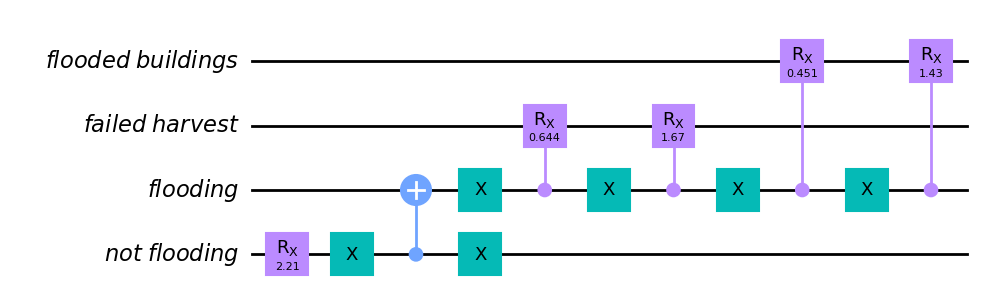

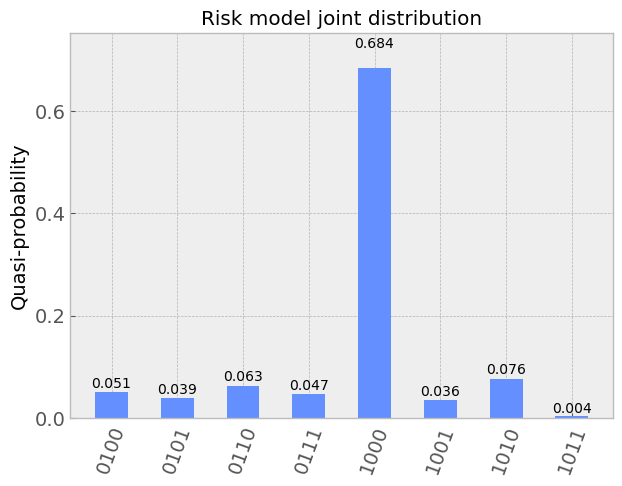

In [2]:
import qiskit as q


plt.style.use('ggplot')

# Make separate quantum qubits (for the naming)
not_flooding = q.QuantumRegister(1, name='not flooding')
flooding = q.QuantumRegister(1, name='flooding')
fld_buildings = q.QuantumRegister(1, name='flooded buildings')
failed_h = q.QuantumRegister(1, name='failed harvest')

# Helper converter function
p_to_theta = lambda x: 2*np.arcsin(np.sqrt(x))

# Create the circuit
risk_model = q.QuantumCircuit(fld_buildings, failed_h, flooding, not_flooding, name='Risk Model')

# Intrinsic not flooding
risk_model.rx(p_to_theta(0.8), not_flooding)

# Add the CNOT with the control state as '0'
risk_model.x(not_flooding)
risk_model.cnot(not_flooding, flooding)
risk_model.x(not_flooding)

# The intrinsic probability for failed harvest occurs when there's no flooding
risk_model.x(flooding)
risk_model.crx(p_to_theta(0.1), flooding, failed_h)
risk_model.x(flooding)

# Calculate the P(failed harvest | flooding)
p = 1 - (1 - 0.1) * (1 - 0.5)
risk_model.crx(p_to_theta(p), flooding, failed_h, ctrl_state='1')

# The same for flooded buildings
risk_model.x(flooding)
risk_model.crx(p_to_theta(0.05), flooding, fld_buildings)
risk_model.x(flooding)
p = 1 - (1 - 0.05) * (1 - 0.4)
risk_model.crx(p_to_theta(p), flooding, fld_buildings, ctrl_state='1')

# Draw the circuit with matplotlib
display(risk_model.draw(output='mpl'))

risk_model.measure_all()

# simulator = Aer.get_backend('aer_simulator')
# job = simulator.run(risk_model, shots=None)

sampler = Sampler()
job = sampler.run(risk_model, shots=None)
qp = job.result().quasi_dists[0].binary_probabilities()
    

with plt.style.context('bmh'):
    display(plot_distribution(qp, title='Risk model joint distribution'))

### Noisy calculations:

global phase: 3π/2
                     ┌─────────┐                                                                                                                                        ┌───┐┌────────────────────────┐┌───┐┌─────────────┐┌───┐┌───────────────────────┐┌───┐┌──────────────────────┐┌──────────┐ ░ ┌─┐         
flooded buildings: ──┤ Rz(π/2) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ Ry(-0.225513405898131) ├┤ X ├┤ Ry(0.22551) ├┤ X ├┤ Ry(-0.71516745604252) ├┤ X ├┤ Ry(0.71516745604252) ├┤ Rz(-π/2) ├─░─┤M├─────────
                     ├─────────┤            ┌───┐┌────────────────────────┐┌───┐┌─────────────┐┌───┐┌────────────────────────┐┌───┐┌───────────────────────┐┌──────────┐└─┬─┘└────────────────────────┘└─┬─┘└─────────────┘└─┬─┘└───────────────────────┘└─┬─┘└──────────────────────┘└──────────┘ ░ └╥┘┌─┐      
   failed harvest: ──┤ Rz(π/2) ├────────────┤ X ├┤ Ry(-0.321750554396642) ├┤ X ├┤ Ry(0.32175) ├┤ X ├┤ Ry(-0.835481873978228) ├┤ X ├┤ Ry(0.835481873978228) ├┤ Rz(-π/2) ├──┼──────────────────────────────┼───────────────────┼─────────────────────────────┼───────────────────────────────────────░──╫─┤M├──────
                     └─────────┘  ┌───┐┌───┐└─┬─┘└────────────────────────┘└─┬─┘└────┬───┬────┘└─┬─┘└────────────────────────┘└─┬─┘└─────────┬───┬─────────┘└──────────┘  │                              │       ┌───┐       │                             │                                       ░  ║ └╥┘┌─┐   
         flooding: ───────────────┤ X ├┤ X ├──■──────────────────────────────■───────┤ X ├───────■──────────────────────────────■────────────┤ X ├────────────────────────■──────────────────────────────■───────┤ X ├───────■─────────────────────────────■───────────────────────────────────────░──╫──╫─┤M├───
                   ┌─────────────┐└─┬─┘├───┤                                         └───┘                                                   └───┘                                                               └───┘                                                                             ░  ║  ║ └╥┘┌─┐
     not flooding: ┤ Rx(-0.9273) ├──■──┤ X ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──╫──╫──╫─┤M├
                   └─────────────┘     └───┘                                                                                                                                                                                                                                                       ░  ║  ║  ║ └╥┘
           meas: 4/═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                                                                                                                                                                                                                      0  1  2  3

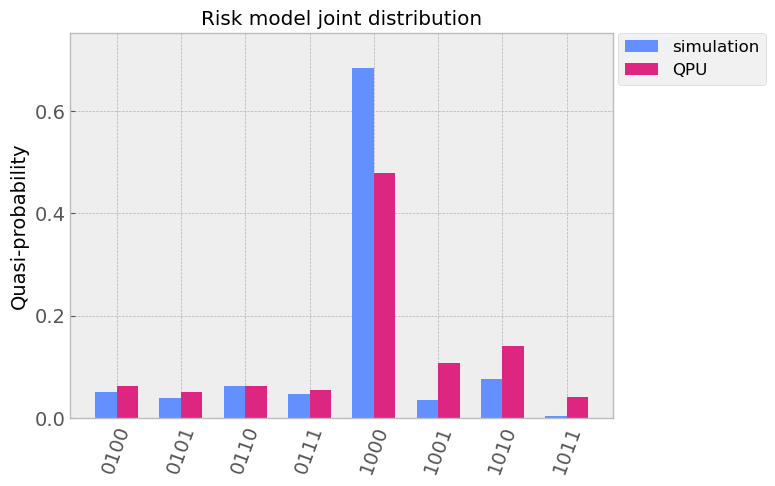

In [3]:
from qiskit_aer import AerSimulator

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)


# QuantumError objects
error_gate1 = depolarizing_error(0.05,1)
error_gate2 = depolarizing_error(0.05,2)

# Add errors to noise model
noise_dep = NoiseModel()
noise_dep.add_all_qubit_quantum_error(error_gate1, ["rx","rz","ry","x"])
noise_dep.add_all_qubit_quantum_error(error_gate2, ["cx"])



t_risk_model = transpile(risk_model, basis_gates=['rx','rz','ry','x','cx'], optimization_level=1)
display(t_risk_model.draw(fold=-1))

# sim_noise = Aer.get_backend('aer_simulator', noise_model=noise_bit_flip)
sim_noise = AerSimulator(noise_model=noise_dep)

job = sim_noise.run(t_risk_model, shots=5000)
qp_noisy = job.result().get_counts()
    

get_dict_subset = lambda dict,keys: {key: dict[key] for key in keys if key in dict}


with plt.style.context('bmh'):
    display(
        plot_distribution([qp,get_dict_subset(qp_noisy, qp.keys())], 
                          legend=['simulation','QPU'], 
                          title='Risk model joint distribution',
                          bar_labels=False))

### ZNE mitigation:

In [43]:
from scipy.optimize import curve_fit


def get_locally_folded_circuit(circuit: QuantumCircuit, noise_factor:float):
    
    if noise_factor<1:
        raise ValueError("Noise factor descreasing noise. Only noise amplification is possible.")
    
    folded_circ = QuantumCircuit(*circuit.qregs)
    
    n_folds = int((noise_factor-1)//2)
    additional_fold_chance = ((noise_factor-1)/2)-n_folds
    
    
    for gate in circuit.data:
        folded_circ.append(*gate)
        for _ in range(n_folds):
            folded_circ.append(gate[0].inverse(), gate[1])
            folded_circ.append(*gate)

        if additional_fold_chance>np.random.rand():
            folded_circ.append(gate[0].inverse(), gate[1])
            folded_circ.append(*gate)

    return folded_circ
    
n_shots = 10000
noise_levels = [1.5, 2, 3]


qps_noisy = []
for noise_level in noise_levels:
    folded_circ = get_locally_folded_circuit(t_risk_model.remove_final_measurements(inplace=False),
                                              noise_factor=noise_level)
    
    folded_circ.measure_all()
    print(f"Circuit for noise factor={noise_level}")
    display(folded_circ.draw(fold=-1))
    
    job = sim_noise.run(folded_circ, shots=n_shots)
    qp_noisy = job.result().get_counts()
    qps_noisy.append(qp_noisy)


qps_noisy

Circuit for noise factor=1.5


┌─────────┐                                                                                                                                                                                   ┌───┐┌────────────────────────┐┌───┐┌─────────────┐┌───┐┌───────────────────────┐┌───┐┌───┐┌───┐┌──────────────────────┐┌───────────────────────┐┌──────────────────────┐┌──────────┐ ░ ┌─┐         
flooded buildings: ──┤ Rz(π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ Ry(-0.225513405898131) ├┤ X ├┤ Ry(0.22551) ├┤ X ├┤ Ry(-0.71516745604252) ├┤ X ├┤ X ├┤ X ├┤ Ry(0.71516745604252) ├┤ Ry(-0.71516745604252) ├┤ Ry(0.71516745604252) ├┤ Rz(-π/2) ├─░─┤M├─────────
                     ├─────────┤  ┌──────────┐┌─────────┐          ┌───┐┌───┐┌───┐┌────────────────────────┐┌───┐┌─────────────┐┌───┐┌───┐┌───┐┌────────────────────────┐┌───┐┌───────────────────────┐┌──────────┐└─┬─┘└────────────────────────┘└─┬─┘└─────────────┘└─┬─┘└───────────────────────┘└─┬─┘└─┬─┘└─┬─┘└──────────────────────┘└───────────────────────┘└──────────────────────┘└──────────┘ ░ └╥┘┌─┐      
   failed harvest: ──┤ Rz(π/2) ├──┤ Rz(-π/2) ├┤ Rz(π/2) ├──────────┤ X ├┤ X ├┤ X ├┤ Ry(-0.321750554396642) ├┤ X ├┤ Ry(0.32175) ├┤ X ├┤ X ├┤ X ├┤ Ry(-0.835481873978228) ├┤ X ├┤ Ry(0.835481873978228) ├┤ Rz(-π/2) ├──┼──────────────────────────────┼───────────────────┼─────────────────────────────┼────┼────┼────────────────────────────────────────────────────────────────────────────────────────░──╫─┤M├──────
                     └─────────┘  └──┬───┬───┘└──┬───┬──┘┌───┐┌───┐└─┬─┘└─┬─┘└─┬─┘└────────────────────────┘└─┬─┘└────┬───┬────┘└─┬─┘└─┬─┘└─┬─┘└────────────────────────┘└─┬─┘└─────────┬───┬─────────┘└──────────┘  │                              │       ┌───┐       │                             │    │    │                                                                                        ░  ║ └╥┘┌─┐   
         flooding: ──────────────────┤ X ├───────┤ X ├───┤ X ├┤ X ├──■────■────■──────────────────────────────■───────┤ X ├───────■────■────■──────────────────────────────■────────────┤ X ├────────────────────────■──────────────────────────────■───────┤ X ├───────■─────────────────────────────■────■────■────────────────────────────────────────────────────────────────────────────────────────░──╫──╫─┤M├───
                   ┌─────────────┐   └─┬─┘       └─┬─┘   └─┬─┘├───┤                                                   └───┘                                                             └───┘                                                               └───┘                                                                                                                                        ░  ║  ║ └╥┘┌─┐
     not flooding: ┤ Rx(-0.9273) ├─────■───────────■───────■──┤ X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──╫──╫──╫─┤M├
                   └─────────────┘                            └───┘                                                                                                                                                                                                                                                                                                                                      ░  ║  ║  ║ └╥┘
           meas: 4/══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════

Circuit for noise factor=2


┌─────────┐                                                                                                                                                                                                                                                                                   ┌───┐                         ┌───┐            ┌───┐┌────────────────────────┐┌───────────────────────┐┌────────────────────────┐┌───┐┌───┐┌───┐┌─────────────┐┌──────────────┐┌─────────────┐┌───┐┌───┐┌───┐┌───────────────────────┐┌──────────────────────┐┌───────────────────────┐┌───┐┌───┐┌───┐┌──────────────────────┐┌───────────────────────┐┌──────────────────────┐┌──────────┐┌─────────┐┌──────────┐ ░ ┌─┐         
flooded buildings: ──┤ Rz(π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├─────────────────────────┤ X ├────────────┤ X ├┤ Ry(-0.225513405898131) ├┤ Ry(0.225513405898131) ├┤ Ry(-0.225513405898131) ├┤ X ├┤ X ├┤ X ├┤ Ry(0.22551) ├┤ Ry(-0.22551) ├┤ Ry(0.22551) ├┤ X ├┤ X ├┤ X ├┤ Ry(-0.71516745604252) ├┤ Ry(0.71516745604252) ├┤ Ry(-0.71516745604252) ├┤ X ├┤ X ├┤ X ├┤ Ry(0.71516745604252) ├┤ Ry(-0.71516745604252) ├┤ Ry(0.71516745604252) ├┤ Rz(-π/2) ├┤ Rz(π/2) ├┤ Rz(-π/2) ├─░─┤M├─────────
                     ├─────────┤  ┌──────────┐┌─────────┐┌───┐┌────────────────────────┐┌───────────────────────┐┌────────────────────────┐┌───┐┌───┐┌───┐┌─────────────┐┌───┐┌────────────────────────┐┌───────────────────────┐┌────────────────────────┐┌───┐┌───────────────────────┐┌────────────────────────┐└─┬─┘┌───────────────────────┐└─┬─┘┌──────────┐└─┬─┘└──────┬─────────┬───────┘└──────┬──────────┬─────┘└────────────────────────┘└─┬─┘└─┬─┘└─┬─┘└─────────────┘└──────────────┘└─────────────┘└─┬─┘└─┬─┘└─┬─┘└───────────────────────┘└──────────────────────┘└───────────────────────┘└─┬─┘└─┬─┘└─┬─┘└──────────────────────┘└───────────────────────┘└──────────────────────┘└──────────┘└─────────┘└──────────┘ ░ └╥┘┌─┐      
   failed harvest: ──┤ Rz(π/2) ├──┤ Rz(-π/2) ├┤ Rz(π/2) ├┤ X ├┤ Ry(-0.321750554396642) ├┤ Ry(0.321750554396642) ├┤ Ry(-0.321750554396642) ├┤ X ├┤ X ├┤ X ├┤ Ry(0.32175) ├┤ X ├┤ Ry(-0.835481873978228) ├┤ Ry(0.835481873978228) ├┤ Ry(-0.835481873978228) ├┤ X ├┤ Ry(0.835481873978228) ├┤ Ry(-0.835481873978228) ├──┼──┤ Ry(0.835481873978228) ├──┼──┤ Rz(-π/2) ├──┼─────────┤ Rz(π/2) ├───────────────┤ Rz(-π/2) ├──────────────────────────────────┼────┼────┼──────────────────────────────────────────────────┼────┼────┼──────────────────────────────────────────────────────────────────────────────┼────┼────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────░──╫─┤M├──────
                     └─────────┘  └──┬───┬───┘└──┬───┬──┘└─┬─┘└────────────────────────┘└───────────────────────┘└────────────────────────┘└─┬─┘└─┬─┘└─┬─┘└────┬───┬────┘└─┬─┘└────────────────────────┘└───────────────────────┘└────────────────────────┘└─┬─┘└─────────┬───┬─────────┘└────────────────────────┘  │  └───────────────────────┘  │  └──────────┘  │         └─────────┘               └──────────┘                                  │    │    │       ┌───┐                                      │    │    │                                                                              │    │    │                                                                                                               ░  ║ └╥┘┌─┐   
         flooding: ──────────────────┤ X ├───────┤ X ├─────■─────────────────────────────────────────────────────────────────────────────────■────■────■───────┤ X ├───────■─────────────────────────────────────────────────────────────────────────────────■────────────┤ X ├──────────────────────────────────────■─────────────────────────────■────────────────■───────────────────────────────────────

Circuit for noise factor=3


┌─────────┐   ┌──────────┐   ┌─────────┐                                                                                                                                                                                                                                                                                                                                                                                            ┌───┐           ┌───┐            ┌───┐┌────────────────────────┐┌───────────────────────┐┌────────────────────────┐┌───┐┌───┐┌───┐┌─────────────┐┌──────────────┐┌─────────────┐┌───┐┌───┐┌───┐┌───────────────────────┐┌──────────────────────┐┌───────────────────────┐┌───┐┌───┐┌───┐┌──────────────────────┐┌───────────────────────┐┌──────────────────────┐┌──────────┐┌─────────┐┌──────────┐ ░ ┌─┐         
flooded buildings: ──┤ Rz(π/2) ├───┤ Rz(-π/2) ├───┤ Rz(π/2) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├───────────┤ X ├────────────┤ X ├┤ Ry(-0.225513405898131) ├┤ Ry(0.225513405898131) ├┤ Ry(-0.225513405898131) ├┤ X ├┤ X ├┤ X ├┤ Ry(0.22551) ├┤ Ry(-0.22551) ├┤ Ry(0.22551) ├┤ X ├┤ X ├┤ X ├┤ Ry(-0.71516745604252) ├┤ Ry(0.71516745604252) ├┤ Ry(-0.71516745604252) ├┤ X ├┤ X ├┤ X ├┤ Ry(0.71516745604252) ├┤ Ry(-0.71516745604252) ├┤ Ry(0.71516745604252) ├┤ Rz(-π/2) ├┤ Rz(π/2) ├┤ Rz(-π/2) ├─░─┤M├─────────
                     ├─────────┤   ├──────────┤   ├─────────┤                                ┌───┐┌───┐┌───┐┌────────────────────────┐┌───────────────────────┐┌────────────────────────┐┌───┐┌───┐┌───┐┌─────────────┐┌──────────────┐┌─────────────┐┌───┐┌───┐┌───┐┌────────────────────────┐┌───────────────────────┐┌────────────────────────┐┌───┐┌───┐┌───┐┌───────────────────────┐┌────────────────────────┐┌───────────────────────┐┌──────────┐└─┬─┘┌─────────┐└─┬─┘┌──────────┐└─┬─┘└────────────────────────┘└───────────────────────┘└────────────────────────┘└─┬─┘└─┬─┘└─┬─┘└─────────────┘└──────────────┘└─────────────┘└─┬─┘└─┬─┘└─┬─┘└───────────────────────┘└──────────────────────┘└───────────────────────┘└─┬─┘└─┬─┘└─┬─┘└──────────────────────┘└───────────────────────┘└──────────────────────┘└──────────┘└─────────┘└──────────┘ ░ └╥┘┌─┐      
   failed harvest: ──┤ Rz(π/2) ├───┤ Rz(-π/2) ├───┤ Rz(π/2) ├────────────────────────────────┤ X ├┤ X ├┤ X ├┤ Ry(-0.321750554396642) ├┤ Ry(0.321750554396642) ├┤ Ry(-0.321750554396642) ├┤ X ├┤ X ├┤ X ├┤ Ry(0.32175) ├┤ Ry(-0.32175) ├┤ Ry(0.32175) ├┤ X ├┤ X ├┤ X ├┤ Ry(-0.835481873978228) ├┤ Ry(0.835481873978228) ├┤ Ry(-0.835481873978228) ├┤ X ├┤ X ├┤ X ├┤ Ry(0.835481873978228) ├┤ Ry(-0.835481873978228) ├┤ Ry(0.835481873978228) ├┤ Rz(-π/2) ├──┼──┤ Rz(π/2) ├──┼──┤ Rz(-π/2) ├──┼─────────────────────────────────────────────────────────────────────────────────┼────┼────┼──────────────────────────────────────────────────┼────┼────┼──────────────────────────────────────────────────────────────────────────────┼────┼────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────░──╫─┤M├──────
                     └─────────┘   └──────────┘   └─────────┘  ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐└─┬─┘└─┬─┘└─┬─┘└────────────────────────┘└───────────────────────┘└────────────────────────┘└─┬─┘└─┬─┘└─┬─┘└────┬───┬────┘└────┬───┬─────┘└────┬───┬────┘└─┬─┘└─┬─┘└─┬─┘└────────────────────────┘└───────────────────────┘└────────────────────────┘└─┬─┘└─┬─┘└─┬─┘└─────────┬───┬─────────┘└─────────┬───┬──────────┘└─────────┬───┬─────────┘└──────────┘  │  └─────────┘  │  └──────────┘  │                                                                                 │    │    │       ┌───┐          ┌───┐           ┌───┐       │    │    │           

[{'1100': 695,
  '0000': 411,
  '1000': 2386,
  '1010': 1112,
  '1001': 913,
  '1101': 628,
  '0110': 451,
  '1110': 567,
  '0001': 176,
  '0010': 303,
  '0111': 429,
  '1111': 513,
  '1011': 410,
  '0100': 446,
  '0101': 422,
  '0011': 138},
 {'1000': 1862,
  '1100': 778,
  '0110': 392,
  '1111': 553,
  '0100': 407,
  '1101': 731,
  '1001': 1103,
  '1010': 1034,
  '0111': 382,
  '0001': 252,
  '0010': 291,
  '1110': 564,
  '1011': 695,
  '0101': 367,
  '0011': 220,
  '0000': 369},
 {'1000': 1377,
  '1011': 655,
  '1001': 881,
  '0001': 311,
  '0111': 400,
  '1111': 668,
  '0100': 429,
  '1110': 724,
  '1101': 803,
  '1010': 987,
  '0010': 418,
  '0110': 404,
  '0000': 468,
  '1100': 815,
  '0011': 250,
  '0101': 410}]

C:\Users\marekowa\AppData\Local\Temp\ipykernel_23928\1430724589.py:14: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(exponential_function, noise_levels, state_probs, bounds=(-1., 1.))


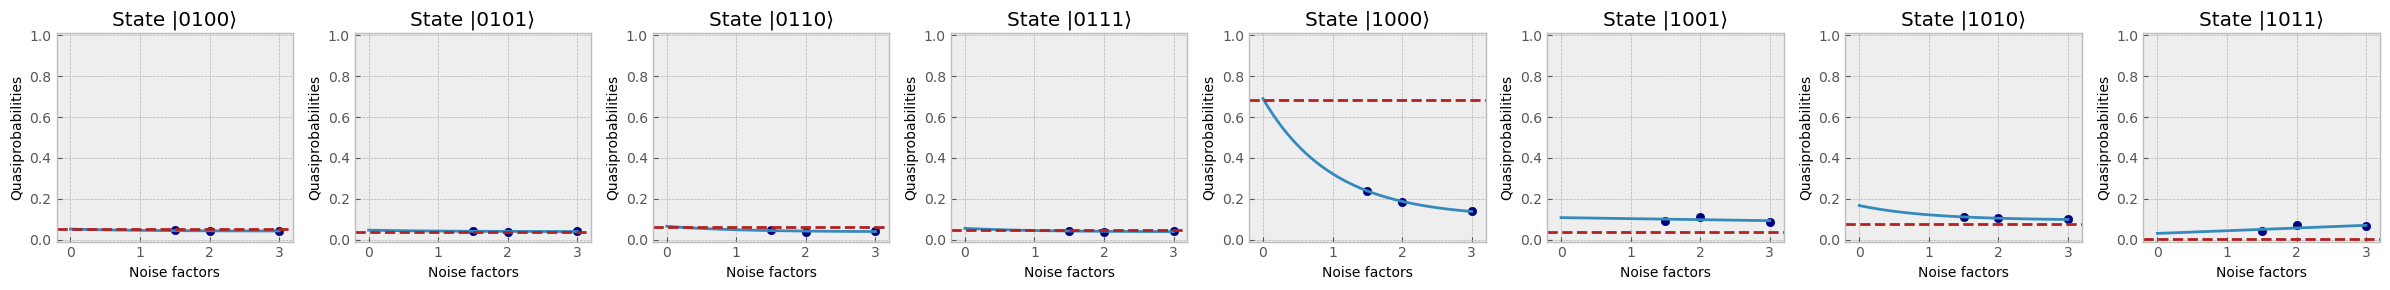

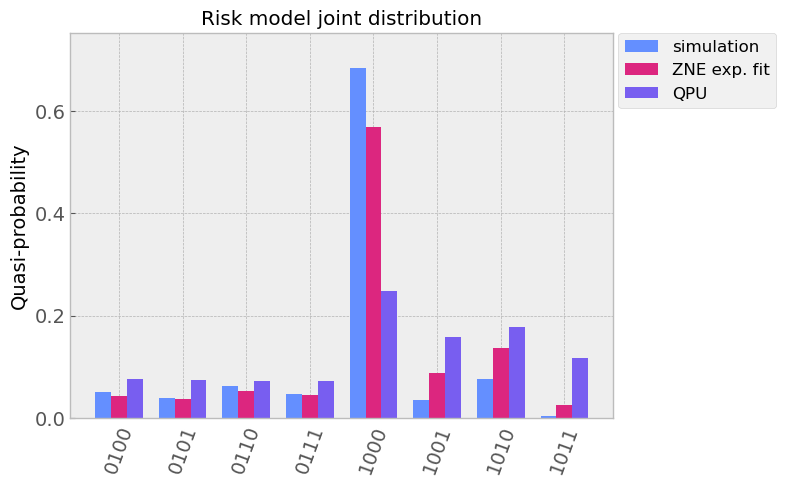

In [44]:
with plt.style.context('bmh'):
    states = list(qp.keys())
    
    fig, axs = plt.subplots(1,len(states),figsize=(3*len(states),3))
    
    mit_values_expfit = []
    for i, state in enumerate(states):
        state_probs = [qp_noisy[state]/n_shots for qp_noisy in qps_noisy]
        # Define the exponential function
        def exponential_function(x, a, b, c):
            return a * np.exp(b * x) + c

        # Fit the data using curve_fit
        popt, pcov = curve_fit(exponential_function, noise_levels, state_probs, bounds=(-1., 1.))
        x_fit = np.linspace(0, max(noise_levels), 101)
        y_fit = exponential_function(x_fit, *popt)
        mit_values_expfit.append(y_fit[0])
        
        axs[i].scatter(noise_levels, state_probs, color='navy', label='raw probs')
        axs[i].plot(x_fit, y_fit, label='exp. func. fit')
        axs[i].axhline(qp[state], linestyle='--', color='firebrick', label=f'ideal prob={qp[state]:.2%}')
        
        axs[i].set_ylim(-0.01, 1.01)
        axs[i].set_xlim(-0.2, max(noise_levels)+0.2)
        axs[i].set_title(f'State |{state}⟩')
        axs[i].set_ylabel("Quasiprobabilities")
        axs[i].set_xlabel('Noise factors')
    # plt.legend()
    plt.tight_layout()
    plt.show()
    
exp_fit = {key:value for key, value in zip(states, mit_values_expfit)}

with plt.style.context('bmh'):
    display(
        plot_distribution([qp,exp_fit,get_dict_subset(qp_noisy,qp.keys())], 
                          legend=['simulation','ZNE exp. fit','QPU'], 
                          title='Risk model joint distribution',
                          bar_labels=False))

### Objective function:

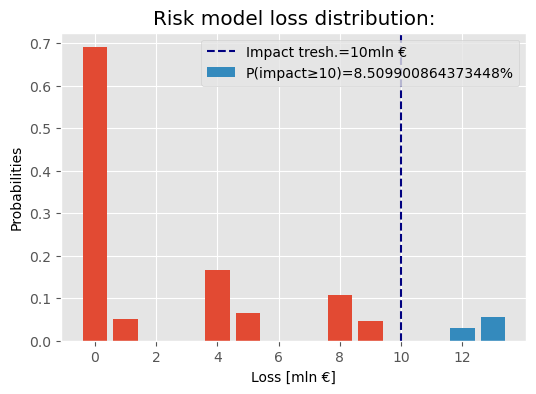

In [45]:
impacts = [8, 4, 1, 0][::-1]
n_events = len(impacts)

qps = np.zeros((2**n_events))

for key, value in exp_fit.items():
    qps[int(key, base=2)] = value

occurencies = [format(i, f'0{n_events}b') for i in range(2**n_events)]
joint_impacts = [sum([impacts[impact_idx] if flag=='1' else 0 for impact_idx, flag in enumerate(occ)]) for occ in occurencies]

unique_joint_impacts = np.unique(joint_impacts)
uji_qps = np.zeros(unique_joint_impacts.shape)

for imp_idx, imp in enumerate(unique_joint_impacts):
    for qps_idx in np.argwhere(np.array(joint_impacts)==imp):
        uji_qps[imp_idx]+= qps[qps_idx]


threshold = 10

plt.subplots(1,1, figsize=(6,4))
plt.bar(unique_joint_impacts, 
        uji_qps)
plt.bar(unique_joint_impacts[unique_joint_impacts>threshold], 
        uji_qps[unique_joint_impacts>threshold],
        label=f'P(impact≥{threshold})={100*uji_qps[unique_joint_impacts>threshold].sum()}%')
plt.axvline(10, color='navy', linestyle='--', label=f'Impact tresh.={threshold}mln €')

plt.title('Risk model loss distribution:')
plt.xticks(range(0,14,2), [f'{x:.0f}' for x in range(0,14,2)])
plt.xlabel("Loss [mln €]")
plt.ylabel('Probabilities')

plt.legend()

plt.show()

In [49]:
p_impact = 100*uji_qps[unique_joint_impacts>threshold].sum()
print(f"Objective function mitigated output: {p_impact:.3f} %",)

Objective function mitigated output: 8.510 %


You have all neccessary ingredients! Let's go into coding!